# NLP Modeling

How do we quantify a document?

- [Setup](#Setup)
- [Data Representation](#Data-Representation)
    - [Bag of Words](#Bag-of-Words)
    - [TF-IDF](#tf-idf)
    - [Bag Of Ngrams](#bag-of-ngrams)
- [Modeling](#modeling)
    - [Modeling Results](#modeling-results)
- [Next Steps](#next-steps)

## Setup

In [1]:
from pprint import pprint
import pandas as pd
import nltk
import re

def clean(text: str) -> list:
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = set(nltk.corpus.stopwords.words('english'))
    text = (text.encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split() # tokenization
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

## Data Representation

Simple data for demonstration.

In [2]:
data = [
    'Python is pretty cool',
    'Python is a nice programming language with nice syntax',
    'I think SQL is cool too'
]

In [3]:
pprint(data)

['Python is pretty cool',
 'Python is a nice programming language with nice syntax',
 'I think SQL is cool too']


### Bag of Words

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

# same basic process as any sklearn transformation:
# make the thing
cv = CountVectorizer()
# use the thing
bag_of_words = cv.fit_transform(data)

In [5]:
bag_of_words

<3x12 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>

In [6]:
data

['Python is pretty cool',
 'Python is a nice programming language with nice syntax',
 'I think SQL is cool too']

In [7]:
bag_of_words.todense()

matrix([[1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 1, 2, 0, 1, 1, 0, 1, 0, 0, 1],
        [1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0]])

Here `bag_of_words` is a **sparse matrix**. Usually you should keep it as such,
but for demonstration we'll view the data within.

In [8]:
cv.get_feature_names_out()

array(['cool', 'is', 'language', 'nice', 'pretty', 'programming',
       'python', 'sql', 'syntax', 'think', 'too', 'with'], dtype=object)

In [9]:
cv.vocabulary_

{'python': 6,
 'is': 1,
 'pretty': 4,
 'cool': 0,
 'nice': 3,
 'programming': 5,
 'language': 2,
 'with': 11,
 'syntax': 8,
 'think': 9,
 'sql': 7,
 'too': 10}

In [10]:
# Taking a look at the bag of words transformation for education and diagnostics.
# In practice this is not necesssary and the resulting data might be to big to be reasonably helpful.
bow = pd.DataFrame(bag_of_words.todense())
bow.columns = cv.get_feature_names_out()

In [11]:
data

['Python is pretty cool',
 'Python is a nice programming language with nice syntax',
 'I think SQL is cool too']

In [12]:
bow

,cool,is,language,nice,pretty,programming,python,sql,syntax,think,too,with
0,1,1,0,0,1,0,1,0,0,0,0,0
1,0,1,1,2,0,1,1,0,1,0,0,1
2,1,1,0,0,0,0,0,1,0,1,1,0


In [13]:
pprint(data)

['Python is pretty cool',
 'Python is a nice programming language with nice syntax',
 'I think SQL is cool too']


In [14]:
bow.apply(lambda row: row / row.sum(), axis=1)

,cool,is,language,nice,pretty,programming,python,sql,syntax,think,too,with
0,0.25,0.250,0.000,0.00,0.25,0.000,0.250,0.0,0.000,0.0,0.0,0.000
1,0.00,0.125,0.125,0.25,0.00,0.125,0.125,0.0,0.125,0.0,0.0,0.125
2,0.20,0.200,0.000,0.00,0.00,0.000,0.000,0.2,0.000,0.2,0.2,0.000


### TF-IDF

- term frequency - inverse document frequency
- $\text{tf} \times \text{idf} = \frac{\text{tf}}{\text{df}}$
- a measure that helps identify how important a word is in a document
- combination of how often a word appears in a document (**tf**) and how unqiue the word
  is among documents (**idf**)
- used by search engines
- naturally helps filter out stopwords
- tf is for a single document, idf is for a corpus

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
bag_of_words = tfidf.fit_transform(data)
pprint(data)
pd.DataFrame(bag_of_words.todense(), 
             columns=tfidf.get_feature_names_out())

['Python is pretty cool',
 'Python is a nice programming language with nice syntax',
 'I think SQL is cool too']


,cool,is,language,nice,pretty,programming,python,sql,syntax,think,too,with
0,0.480458,0.373119,0.000000,0.000000,0.631745,0.000000,0.480458,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.197673,0.334689,0.669378,0.000000,0.334689,0.254540,0.000000,0.334689,0.000000,0.000000,0.334689
2,0.383770,0.298032,0.000000,0.000000,0.000000,0.000000,0.000000,0.504611,0.000000,0.504611,0.504611,0.000000


To get the idf score for each word (these aren't terribly usefule themselves):

In [16]:
# zip: put these two things of the same length together
# dict: turn those two associated things into a k: v pair
# pd.Series: turn those keys into indeces, and the values into values
pd.Series(
    dict(
        zip(
            tfidf.get_feature_names_out(), tfidf.idf_
        )
    )
)

cool           1.287682
is             1.000000
language       1.693147
nice           1.693147
pretty         1.693147
programming    1.693147
python         1.287682
sql            1.693147
syntax         1.693147
think          1.693147
too            1.693147
with           1.693147
dtype: float64

### Bag Of Ngrams

For either `CountVectorizer` or `TfidfVectorizer`, you can set the `ngram_range`
parameter.

In [17]:
cv = CountVectorizer(ngram_range=(2, 3))
bag_of_grams = cv.fit_transform(data)

In [18]:
pprint(data)

['Python is pretty cool',
 'Python is a nice programming language with nice syntax',
 'I think SQL is cool too']


In [19]:
pd.DataFrame(bag_of_grams.todense(),
            columns=cv.get_feature_names_out())

,cool too,is cool,is cool too,is nice,is nice programming,is pretty,is pretty cool,language with,language with nice,nice programming,...,programming language with,python is,python is nice,python is pretty,sql is,sql is cool,think sql,think sql is,with nice,with nice syntax
0,0,0,0,0,0,1,1,0,0,0,...,0,1,0,1,0,0,0,0,0,0
1,0,0,0,1,1,0,0,1,1,1,...,1,1,1,0,0,0,0,0,1,1
2,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,1,0,0


## Modeling

In [14]:
from env import get_db_url
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

url = get_db_url('spam_db')
df = pd.read_sql('SELECT * FROM spam', url)
df

,id,label,text
0,0,ham,"Go until jurong point, crazy.. Available only ..."
1,1,ham,Ok lar... Joking wif u oni...
2,2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,3,ham,U dun say so early hor... U c already then say...
4,4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...,...
5567,5567,spam,This is the 2nd time we have tried 2 contact u...
5568,5568,ham,Will Ì_ b going to esplanade fr home?
5569,5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,5570,ham,The guy did some bitching but I acted like i'd...


In [15]:
df['clean_text'] = df.text.apply(clean).apply(' '.join)

In [22]:
# df = df.drop(columns='text_clean')

In [16]:
df

,id,label,text,clean_text
0,0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think go usf life around though
...,...,...,...,...
5567,5567,spam,This is the 2nd time we have tried 2 contact u...,2nd time tried 2 contact u u 750 pound prize 2...
5568,5568,ham,Will Ì_ b going to esplanade fr home?,_ b going esplanade fr home
5569,5569,ham,"Pity, * was in mood for that. So...any other s...",pity mood soany suggestion
5570,5570,ham,The guy did some bitching but I acted like i'd...,guy bitching acted like id interested buying s...


In [17]:
X = df.clean_text
y = df.label
X_train, X_test, y_train, y_test = \
train_test_split(X, y, 
                 test_size=0.2, 
                 random_state=1349)

In [18]:
X_train.head()

2302                        make baby yo tho
4304                     yo come carlos soon
4925    oh yes like torture watching england
1753     jus came back fr lunch wif si u leh
3211                    got divorce lol shes
Name: clean_text, dtype: object

In [19]:
y_train.head()

2302    ham
4304    ham
4925    ham
1753    ham
3211    ham
Name: label, dtype: object

Iterate:

- try out the bag of ngrams
- try out different ways of text prep (stem vs lemmatize)
- etc...

In [20]:
# Whatever transformations we apply to X_train need to be applied to X_test
cv = CountVectorizer()
X_bow = cv.fit_transform(X_train)
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X_bow, y_train)
tree.score(X_bow, y_train)

0.923939869867624

In [21]:
# as with any other sklearn transformation, 
# transform only on our validate and/or test, 
# only fit on train
X_test_bow = cv.transform(X_test)
tree.score(X_test_bow, y_test)

0.9076233183856502

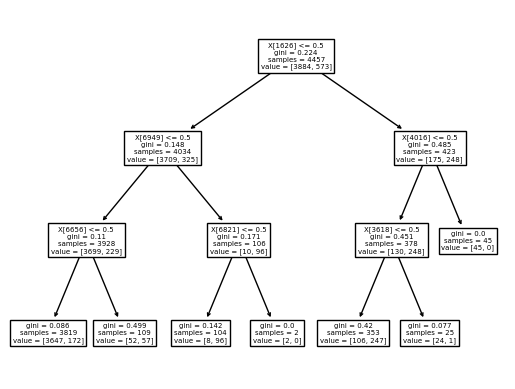

In [23]:
plot_tree(tree);

### Modeling Results

A super-useful feature of decision trees and linear models is that they do some
built-in feature selection through the coefficeints or feature importances:

In [34]:
pd.Series(
    dict(
    zip(cv.get_feature_names_out(), 
    tree.feature_importances_))).sort_values(ascending=False).head()

call     0.434467
txt      0.328833
text     0.107392
later    0.076804
im       0.045085
dtype: float64

## Next Steps

- Try other model types

    [Naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)
    ([`sklearn`
    docs](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html))
    is a very popular classifier for NLP tasks.

- Look at other metrics, is accuracy the best choice here?

- Try ngrams instead of single words

- Try a combination of ngrams and words (`ngram_range=(1, 2)` for words and
  bigrams)

- Try using tf-idf instead of bag of words

- Combine the top `n` performing words with the other features that you have
  engineered (the `CountVectorizer` and `TfidfVectorizer` have a `vocabulary`
  argument you can use to restrict the words used)